## Data Visualization, Linear Models, and Support Vector Machines
## By Emma Corbett
## Fall 2024

The following notebook demonstrates skills related to the following topics:

1. Data Visualization and Analysis
2. Linear Models for Regression and Classification
3. Support Vector Machines

In [1]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.linalg import inv
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import r2_score, accuracy_score
from sklearn.svm import LinearSVC, SVC
from sklearn.compose import make_column_transformer, ColumnTransformer

## **Part 1: Data Visualization and Analysis**

This part focuses on visualizing and analyzing the `insurance.csv` dataset. This data set was secured from https://www.kaggle.com/datasets/awaiskaggler/insurance-csv . 

In [3]:
# Load the dataset
insurance_df = pd.read_csv('insurance.csv')
insurance_df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


**Bar chart to compare the average insurance charges by sex and region:**


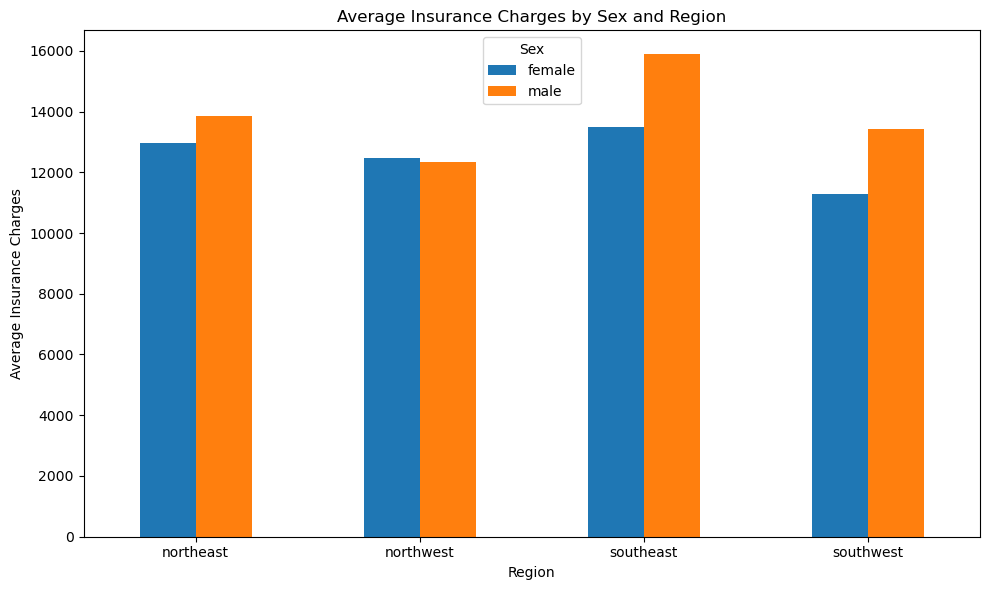

In [4]:

# calculate means by sex and region
averages = insurance_df.groupby(['region', 'sex'])['charges'].mean().unstack()

# Plot in a grouped bar chart
averages.plot(kind='bar', figsize=(10, 6))
plt.title('Average Insurance Charges by Sex and Region')
plt.ylabel('Average Insurance Charges')
plt.xlabel('Region')
plt.xticks(rotation=0)
plt.legend(title='Sex', loc='upper center')

# Show the plot
plt.tight_layout()
plt.show()



**Bar charts to visualize the data distribution sex, region, children, and smoker:**

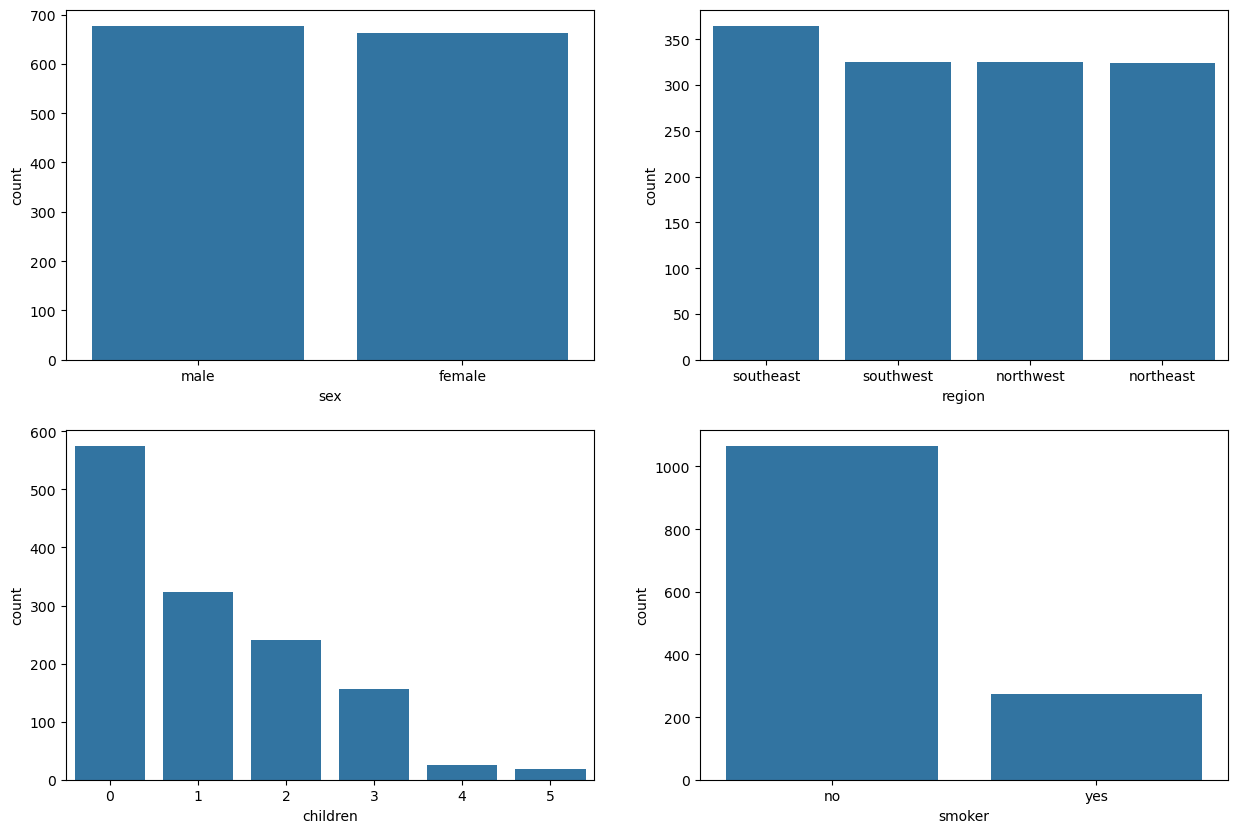

In [6]:

features = ['sex',
           'region',
           'children',
           'smoker']
sex = pd.DataFrame(insurance_df['sex'].value_counts())
region = pd.DataFrame(insurance_df['region'].value_counts())
children = pd.DataFrame(insurance_df['children'].value_counts())
smoker = pd.DataFrame(insurance_df['smoker'].value_counts())
counts = {'sex': sex,
         'region': region,
         'children': children,
         'smoker': smoker}

# Distribution of counts for the features listed above
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
for var, subplot in zip(features, ax.flatten()):
    sns.barplot(x=var, y='count', data=counts[var], ax=subplot)

**Comparing the insurance charges by age and smoker**

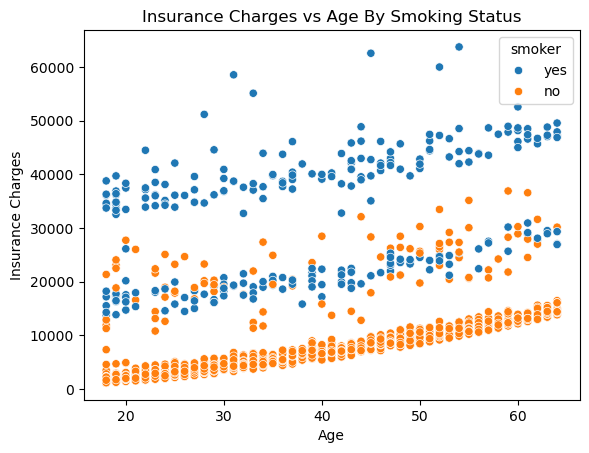

In [7]:

# Create scatter plot for age vs charges with smoker as hue
sns.scatterplot(data=insurance_df, x='age', y='charges', hue='smoker')

plt.xlabel('Age')
plt.ylabel('Insurance Charges')
plt.title('Insurance Charges vs Age By Smoking Status')
plt.show()

## **Part 2: Linear Models for Regression and Classification**

This section implements three linear models: **linear regression, logistic regression, and SVM**.

### **Linear Regression**
My goal is to predict 'insurance charges'.

In [8]:
# Split the dataset into features and labels
insurance_X = insurance_df.drop(columns=['charges'])
insurance_y = insurance_df['charges']

**First, plotting the relationships between age, bmi, children, and region and the target variable `charges`.**

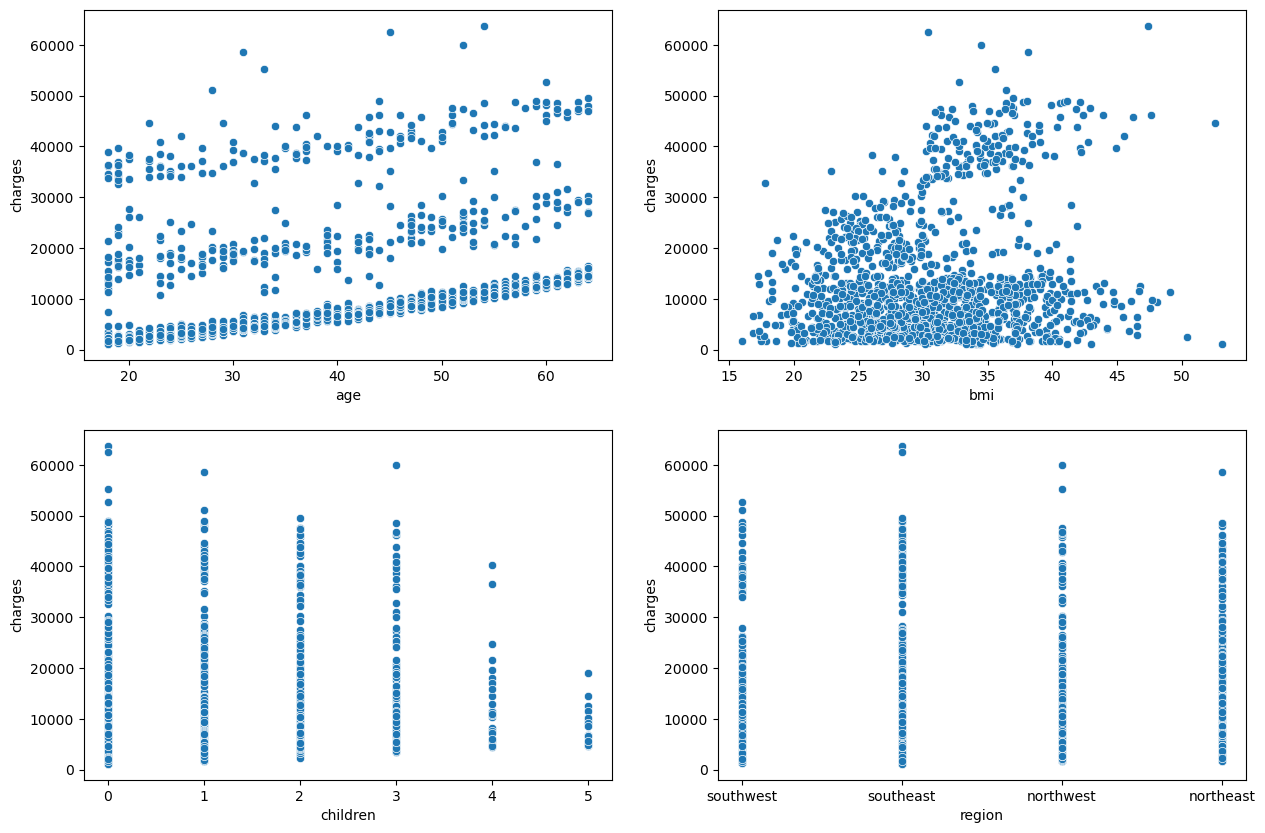

In [9]:
insurance_X_subset = insurance_X.drop(columns=['sex','smoker'])

# Scatter plot of age vs charges
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
for var, subplot in zip(insurance_X_subset, ax.flatten()):
    sns.scatterplot(x=var, y=insurance_y, data=insurance_df, ax=subplot)

### **Data Preprocessing**

Next, I preprocess the data prior to training a linear regression model. Steps include, encoding features, checking for multicollinearity, splitting the dataset, standardizing the feature matrices, and finally adding a column for the bias term. 

**Encoding the categorical variables**

In [11]:
ohe = ['region', 'children','smoker', 'sex']
df_encoded = pd.get_dummies(insurance_X, columns=ohe, dtype='int')
df_encoded = df_encoded.drop(columns=['smoker_yes', 'sex_male', 'region_northeast', 'children_5'])

**Correlation Matrix**

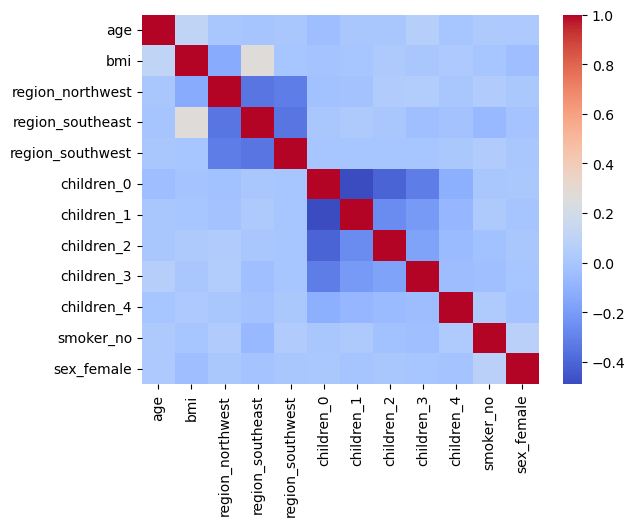

In [12]:

corr_matrix = df_encoded.corr()

# Plot correlation matrix
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.show()

**Split the dataset**

In [14]:

features = df_encoded.columns.values.tolist()
x_dev, insurance_X_test, y_dev, insurance_y_test = train_test_split(df_encoded, insurance_y, random_state=42, test_size=0.2, train_size=0.8)
insurance_X_train, insurance_X_val, insurance_y_train, insurance_y_val = train_test_split(x_dev, y_dev, random_state=84, test_size=0.25,train_size =0.75)

**Standardize the columns in the feature matrices**

In [15]:

transformer = ColumnTransformer(transformers=[
        ('scaler', StandardScaler(), [0, 1])],
    remainder='passthrough')

insurance_X_test = transformer.fit_transform(insurance_X_test)

insurance_X_train = transformer.transform(insurance_X_train)

insurance_X_val = transformer.transform(insurance_X_val)


In [16]:
# Adding a column of ones to include the bias term

insurance_X_train = np.hstack([np.ones((insurance_X_train.shape[0], 1)), insurance_X_train])
insurance_X_val = np.hstack([np.ones((insurance_X_val.shape[0], 1)), insurance_X_val])
insurance_X_test = np.hstack([np.ones((insurance_X_test.shape[0], 1)), insurance_X_test])

### Linear Regression

Below is an implementation of a custom `LinearRegression` class using L2 regularization (Ridge Regression).

In [17]:
class LinearRegression():
    '''
    Linear regression model with L2-regularization (ridge regression).

    Attributes
    ----------
    alpha: regularization parameter
    w: (n x 1) weight vector
    '''
    def __init__(self, alpha=0):
        self.alpha = alpha
        self.w = None

    def train(self, X, y):
        '''Trains model using ridge regression closed-form solution.
        Parameters:
        X : (m x n) feature matrix
        y: (m x 1) label vector
        '''
        m, n = X.shape
        I = np.identity(n)
        A = X.T @ X + self.alpha * I
        b = X.T @ y
        
        self.w = np.linalg.solve(A, b)

    def predict(self, X):
        '''Predicts on X using trained model.
        Parameters:
        X : (m x n) feature matrix
        Returns:
        y_pred: (m x 1) prediction vector
        '''
        return X @ self.w


**Train and Evaluate Linear Regression Model**

In [18]:
def get_report(y_pred, y_test):
    """
    Report the first 3 and last 3 predictions on X_test,
    along with the actual labels in y_test.

    Returns:
        A dataframe with 6 rows comparing predictions and actuals.
    """
    preds = np.concatenate([y_pred[:3], y_pred[-3:]])
    actuals = np.concatenate([y_test[:3], y_test[-3:]])
    df_compare = pd.DataFrame({'Prediction': preds,
                               'Actual': actuals})
    df_compare['Position'] = [1, 2, 3, len(y_pred) - 2, len(y_pred) - 1, len(y_pred)]
    df_compare = df_compare.set_index('Position')
    return df_compare

In [19]:

lr_model = LinearRegression()

# train
lr_model.train(insurance_X_train, insurance_y_train)

# predict and report R2 score on training set
train_pred = lr_model.predict(insurance_X_train)
r2_train = r2_score(insurance_y_train, train_pred)

# predict and report R2 score on val set
val_pred = lr_model.predict(insurance_X_val)
r2_val = r2_score(insurance_y_val, val_pred)

# predict and report R2 score on test set
test_pred = lr_model.predict(insurance_X_test)
r2_test = r2_score(insurance_y_test, test_pred)

print("R2 train: " + str(r2_train))
print("R2 val: " + str(r2_val))
print("R2 test: " + str(r2_test) + "\n")

print(get_report(test_pred, insurance_y_test))

R2 train: 0.7546013581549758
R2 val: 0.6929443801159548
R2 test: 0.7793484587913186

            Prediction       Actual
Position                           
1          9584.253105   9095.06825
2          7019.533362   5272.17580
3         36608.140389  29330.98315
266        7513.918745   6067.12675
267       41377.594147  63770.42801
268       12594.406672   9872.70100


In [20]:

mean_train = np.mean(insurance_y_train)
y_mean_train_pred = [mean_train] * insurance_y_train.shape[0]
y_mean_val_pred = [mean_train] * insurance_y_val.shape[0]
y_mean_test_pred = [mean_train] * insurance_y_test.shape[0]

# predict and report R2 score on mean vals
r2_train = r2_score(insurance_y_train, y_mean_train_pred)
r2_val = r2_score(insurance_y_val, y_mean_val_pred)
r2_test = r2_score(insurance_y_test, y_mean_test_pred)

print("R2 train: " + str(r2_train))
print("R2 val: " + str(r2_val))
print("R2 test: " + str(r2_test) + "\n")

R2 train: 0.0
R2 val: -0.022579280288565373
R2 test: -0.004103769493143394



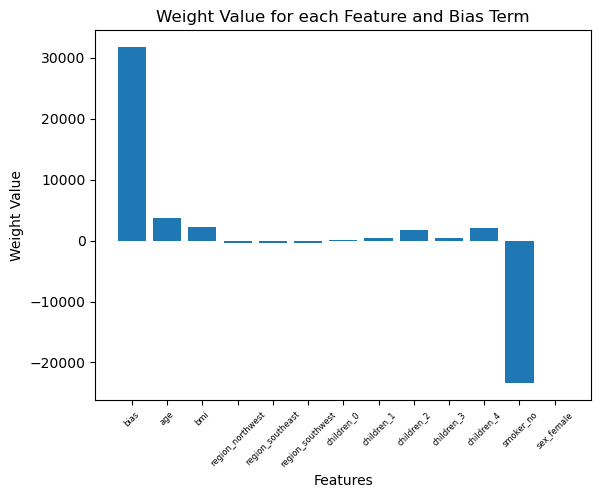

In [21]:

headers = features.copy()
headers.insert(0, 'bias')
plt.bar(headers, lr_model.w)

plt.title('Weight Value for each Feature and Bias Term')
plt.xlabel('Features')
plt.ylabel('Weight Value')
plt.xticks(fontsize=6, rotation=45)
plt.show()

### **Hyperparameter Tuning ($\alpha$)**

Now, I tune the $\alpha$ regularization parameter for ridge regression on the insurance dataset.


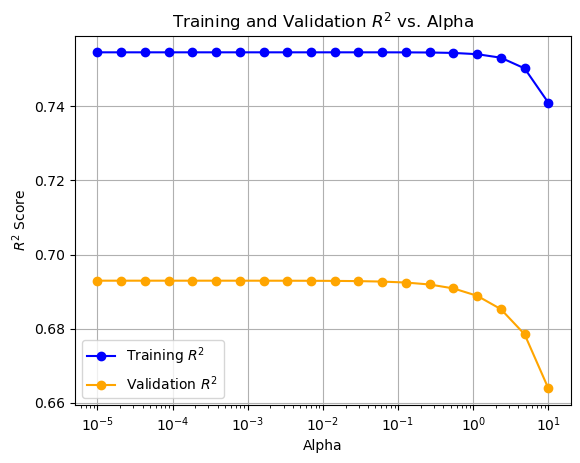

In [23]:

alphas = np.logspace(-5, 1, 20)
train = []
val = []

for alpha in alphas:
    model = LinearRegression(alpha=alpha)
    model.train(insurance_X_train, insurance_y_train)
    
    train_pred = model.predict(insurance_X_train)
    r2_train = r2_score(insurance_y_train, train_pred)
    val_pred = model.predict(insurance_X_val)
    r2_val = r2_score(insurance_y_val, val_pred)
    
    # Save R2 scores
    train.append(r2_train)
    val.append(r2_val)

plt.plot(alphas, train, 'o-', label="Training $R^2$", color="blue")
plt.plot(alphas, val, 'o-', label="Validation $R^2$", color="orange")
plt.xscale("log")
plt.xlabel("Alpha")
plt.ylabel("$R^2$ Score")
plt.title("Training and Validation $R^2$ vs. Alpha")
plt.legend()
plt.grid(True)
plt.show()


### Logistic Regression

To explore logistic regression, I am using loan_data.csv from https://www.kaggle.com/datasets/burak3ergun/loan-data-set

In [25]:

loan_data_df = pd.read_csv('loan_data.csv')
loan_data_df

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


In [26]:
loan_data_df = loan_data_df.drop(columns=['Loan_ID'])

**Handle missing values**

In [27]:

missing_values = loan_data_df.isnull().sum()
print(missing_values)

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64


In [28]:

loan_data_df.dropna(subset=['Married'], inplace=True)
loan_data_df.dropna(subset=['Credit_History'], inplace=True)

# impute numerical values 
loan_amount_mean = loan_data_df['LoanAmount'].mean()
loan_amount_term_median = loan_data_df['Loan_Amount_Term'].median()
loan_data_df['LoanAmount'].fillna(loan_amount_mean, inplace=True)
loan_data_df['Loan_Amount_Term'].fillna(loan_amount_term_median, inplace=True)
nan = "NaN"
loan_data_df['Self_Employed'].fillna(nan, inplace=True)
loan_data_df['Dependents'].fillna(nan, inplace=True)
loan_data_df['Gender'].fillna(nan, inplace=True)

/var/folders/dw/vzw4ly114sx_wbkm_10t616m0000gn/T/ipykernel_21345/2080924804.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  loan_data_df['LoanAmount'].fillna(loan_amount_mean, inplace=True)
/var/folders/dw/vzw4ly114sx_wbkm_10t616m0000gn/T/ipykernel_21345/2080924804.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are se

**Encode the categorical variables.**

In [30]:

ohe = ['Gender', 'Dependents','Self_Employed', 'Credit_History', 'Education', 'Married', 'Property_Area']
df_encoded_loan = pd.get_dummies(loan_data_df, columns=ohe, dtype='int')

**Check distribution of labels**

In [31]:

yes_prob = df_encoded_loan['Loan_Status'].value_counts()['Y']/df_encoded_loan['Loan_Status'].count()
yes_prob

0.6809269162210339

**Plot the correlation matrix**

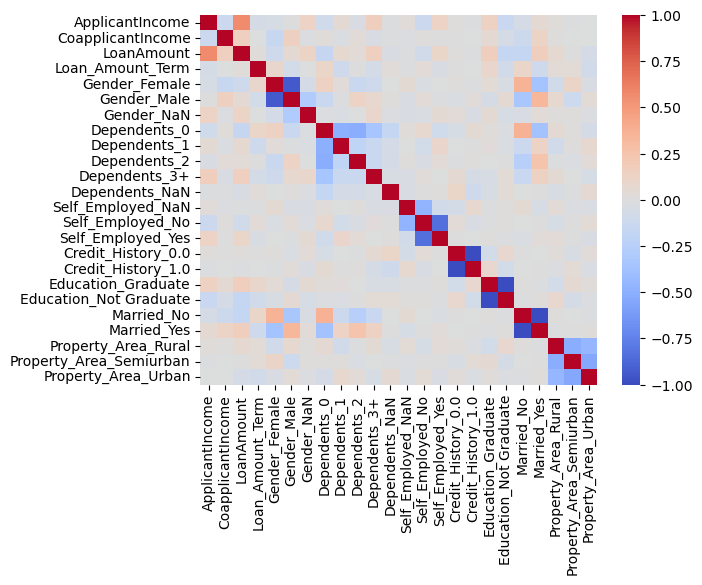

In [33]:

loan_y = df_encoded_loan['Loan_Status']
loan_X = df_encoded_loan.drop(columns=['Loan_Status'])

corr_matrix = loan_X.corr()

# Plot correlation matrix
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.show()

In [34]:


# Dropping features with high correlation/redundant features
loan_X = loan_X.drop(columns=['Gender_Female', 'Dependents_0', 'Self_Employed_No', 'Credit_History_0.0', 'Married_No', 'Education_Graduate', 'Property_Area_Rural'])
loan_features = loan_X.columns.values.tolist()

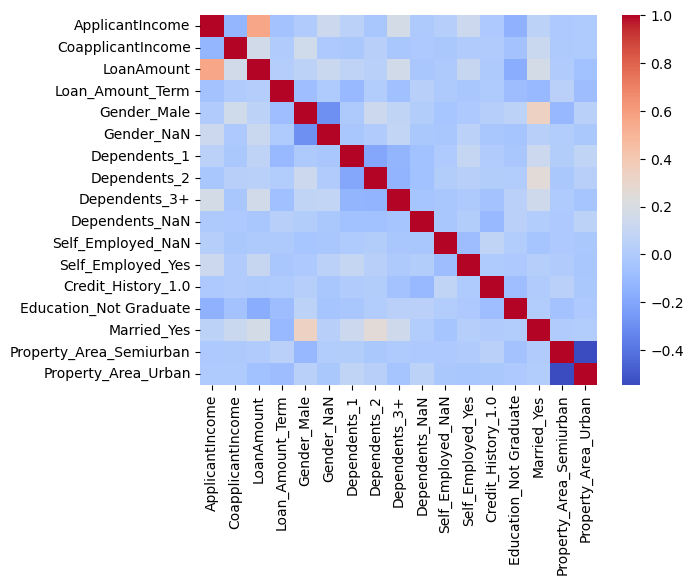

In [35]:

corr_matrix = loan_X.corr()

# Plot correlation matrix
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.show()

**Preprocessing of the data**

In [36]:

loan_y.replace(('Y', 'N'), (1.0, 0.0), inplace=True)
loan_y = loan_y.to_numpy()
loan_y = loan_y.reshape(len(loan_y), 1)

# split the dataset 
x_dev, loan_X_test, y_dev, loan_y_test = train_test_split(loan_X, loan_y, random_state=42, test_size=0.2, train_size=0.8)
loan_X_train, loan_X_val, loan_y_train, loan_y_val = train_test_split(x_dev, y_dev, random_state=84, test_size=0.25,train_size =0.75)

# standardize features
scaler_loan = StandardScaler()
loan_X_test = scaler_loan.fit_transform(loan_X_test)

loan_X_train = scaler_loan.transform(loan_X_train)

loan_X_val = scaler_loan.transform(loan_X_val)

# Add the bias term
loan_X_train = np.hstack([np.ones((loan_X_train.shape[0], 1)), loan_X_train])
loan_X_val = np.hstack([np.ones((loan_X_val.shape[0], 1)), loan_X_val])
loan_X_test = np.hstack([np.ones((loan_X_test.shape[0], 1)), loan_X_test])

/var/folders/dw/vzw4ly114sx_wbkm_10t616m0000gn/T/ipykernel_21345/2224824583.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  loan_y.replace(('Y', 'N'), (1.0, 0.0), inplace=True)


### Implement Logisitc Regression with L2 regularization from Scratch

In [37]:
class LogisticRegression():
    '''
    Logistic regression model with L2 regularization.

    Attributes
    ----------
    alpha: regularization parameter
    t: number of epochs to run gradient descent
    eta: learning rate for gradient descent
    w: (n x 1) weight vector
    '''

    def __init__(self, alpha=0, t=100, eta=1e-3):
        self.alpha = alpha
        self.t = t
        self.eta = eta
        self.w = None

    def train(self, X, y):
        '''Trains logistic regression model using gradient descent
        (sets w to its optimal value).

        Parameters
        ----------
        X : (m x n) feature matrix
        y: (m x 1) label vector

        Returns
        -------
        losses: (t x 1) vector of losses at each epoch of gradient descent
        '''

        loss = list()
        self.w = np.zeros((X.shape[1],1))
        for i in range(self.t):
            self.w = self.w - (self.eta * self.calculate_gradient(X, y))
            loss.append(self.calculate_loss(X, y))
        return loss

    def predict(self, X):
        '''Predicts on X using trained model. Make sure to threshold
        the predicted probability to return a 0 or 1 prediction.

        Parameters
        ----------
        X : (m x n) feature matrix

        Returns
        -------
        y_pred: (m x 1) 0/1 prediction vector
        '''
        y_pred = self.calculate_sigmoid(X.dot(self.w))
        y_pred[y_pred >= 0.5] = 1
        y_pred[y_pred < 0.5] = 0
        return y_pred

    def calculate_loss(self, X, y):
        '''Calculates the logistic regression loss using X, y, w,
        and alpha. Useful as a helper function for train().

        Parameters
        ----------
        X : (m x n) feature matrix
        y: (m x 1) label vector

        Returns
        -------
        loss: (scalar) logistic regression loss
        '''
        return -y.T.dot(np.log(self.calculate_sigmoid(X.dot(self.w)))) - (1-y).T.dot(np.log(1-self.calculate_sigmoid(X.dot(self.w)))) + self.alpha*np.linalg.norm(self.w, ord=2)**2

    def calculate_gradient(self, X, y):
        '''Calculates the gradient of the logistic regression loss
        using X, y, w, and alpha. Useful as a helper function
        for train().

        Parameters
        ----------
        X : (m x n) feature matrix
        y: (m x 1) label vector

        Returns
        -------
        gradient: (n x 1) gradient vector for logistic regression loss
        '''
        return X.T.dot(self.calculate_sigmoid( X.dot(self.w)) - y) + 2*self.alpha*self.w


    def calculate_sigmoid(self, x):
        '''Calculates the sigmoid function on each element in vector x.
        Useful as a helper function for predict(), calculate_loss(),
        and calculate_gradient().

        Parameters
        ----------
        x: (m x 1) vector

        Returns
        -------
        sigmoid_x: (m x 1) vector of sigmoid on each element in x
        '''
        return (1)/(1 + np.exp(-x.astype('float')))

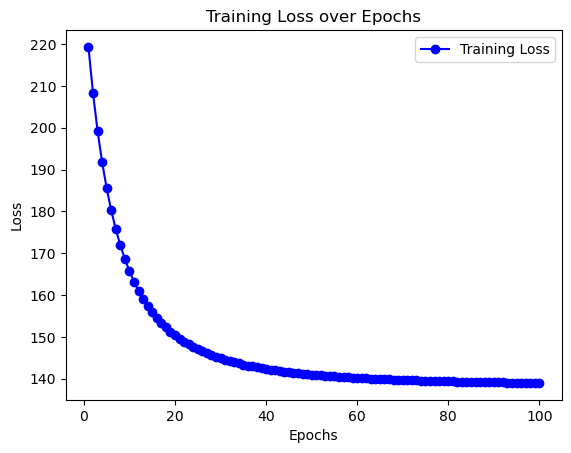

In [38]:

logistic_regression = LogisticRegression()
train_loss = logistic_regression.train(loan_X_train, loan_y_train)
t = range(1, 101)
train_loss = [x[0][0] for x in train_loss]

plt.plot(t, train_loss, 'bo-', label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()


In [39]:
# find best params
best_params = None
best_score = 0

for i in range(20):
    # random selection for values for alpha, eta, and t
    alpha = np.random.uniform(0, 1)
    eta = np.random.uniform(0, 0.001)
    t = np.random.randint(0, 100)
    
    logistic_regression = LogisticRegression(alpha=alpha, t=t, eta=eta)
    logistic_regression.train(loan_X_train, loan_y_train)
    predict = logistic_regression.predict(loan_X_val)
    score = accuracy_score(loan_y_val, predict)

    if score > best_score:
        best_score = score
        best_params = {'alpha': alpha, 'eta': eta, 't': t, 'accuracy': score}
    

In [40]:

# compare accuracy on test data for the two models 
logistic_regression_original = LogisticRegression()
logistic_regression_original.train(loan_X_train, loan_y_train)
predict_original = logistic_regression_original.predict(loan_X_test)
score_original = accuracy_score(loan_y_test, predict_original)

logistic_regression_hyper = LogisticRegression(alpha=best_params['alpha'], t=best_params['t'], eta=best_params['eta'])
logistic_regression_hyper.train(loan_X_train, loan_y_train)
predict_hyper = logistic_regression_hyper.predict(loan_X_test)
score_hyper = accuracy_score(loan_y_test, predict_hyper)

print("Accuracy for original model: ", str(score_original))
print("Accuracy for model with hyperparameters tuned: ", str(score_hyper))


Accuracy for original model:  0.7876106194690266
Accuracy for model with hyperparameters tuned:  0.7964601769911505


### Feature Importance

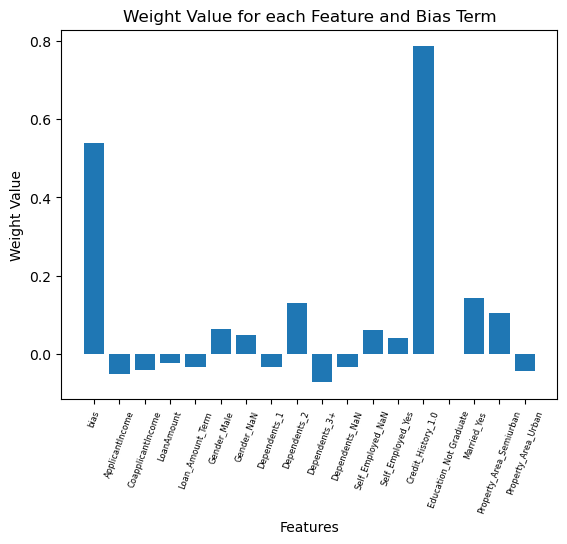

In [41]:

headers = loan_features.copy()
headers.insert(0,'bias')
weights = [x[0] for x in logistic_regression_hyper.w]
plt.bar(headers, weights)

plt.title('Weight Value for each Feature and Bias Term')
plt.xlabel('Features')
plt.ylabel('Weight Value')
plt.xticks(fontsize=6, rotation=70)
plt.show()

### Support Vector Machines

Fiinally, I use support vector machines for classification on the loan dataset.

### Train Primal SVM

In [43]:

primal_svm = LinearSVC(C=0.1, penalty="l2", loss="squared_hinge", dual=False)
loan_y_train_svm = [x[0] for x in loan_y_train]
primal_svm.fit(loan_X_train, loan_y_train_svm)

train_predict = primal_svm.predict(loan_X_train)
train_accuracy = accuracy_score(loan_y_train_svm, train_predict)

print("Training accuracy: ", str(train_accuracy))

val_predict = primal_svm.predict(loan_X_val)
val_accuracy = accuracy_score(loan_y_val, val_predict)

print("Validation accuracy: ", str(val_accuracy))

test_predict = primal_svm.predict(loan_X_test)
test_accuracy = accuracy_score(loan_y_test, test_predict)

print("Test accuracy: ", str(test_accuracy))

Training accuracy:  0.8273809523809523
Validation accuracy:  0.7678571428571429
Test accuracy:  0.7876106194690266


### Train Dual SVM

In [44]:

dual_svm = SVC(kernel='linear', C=0.1)
dual_svm.fit(loan_X_train, loan_y_train_svm)

train_predict = dual_svm.predict(loan_X_train)
train_accuracy = accuracy_score(loan_y_train_svm, train_predict)

print("Training accuracy: ", str(train_accuracy))

val_predict = dual_svm.predict(loan_X_val)
val_accuracy = accuracy_score(loan_y_val, val_predict)

print("Validation accuracy: ", str(val_accuracy))

test_predict = dual_svm.predict(loan_X_test)
test_accuracy = accuracy_score(loan_y_test, test_predict)

print("Test accuracy: ", str(test_accuracy))

Training accuracy:  0.8273809523809523
Validation accuracy:  0.7946428571428571
Test accuracy:  0.7964601769911505


In [2]:
!jupyter nbconvert --to html HW1_ec3745.ipynb

[NbConvertApp] Converting notebook HW1_ec3745.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 11 image(s).
[NbConvertApp] Writing 1313760 bytes to HW1_ec3745.html
